In [1]:
%load_ext autoreload

import os
import math, random
import scipy.stats as stats
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

import torch
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
import ignite.metrics as ignite_metrics

In [463]:
# Fix constants and helper methods
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def rounded_sigmoid(logits: torch.Tensor) -> torch.Tensor:
    return torch.round(torch.sigmoid(logits))


def seed_everything(seed: int) -> None:
    "seeding function for reproducibility"
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
NUM_SAMPLES = 5000
P0 = 0.5
SIG_Z0 = 1#Originally 3 and 5
SIG_Z1 = 3
T_TAU_Z0 = 0.75
T_TAU_Z1 = 0.25
# visualize tau (represents the prob of getting y = 1, 
# i.e y = Bern(tau))
TAU = np.zeros((2, 2))
for z in range(2):
    for t in range(2):
        TAU[z, t] = sigmoid(1.5 * (z + 1.3 * (2 * t - 1))) # other
        #TAU[z, t] = sigmoid(3 * (z + 2 * (2 * t - 1)))

PLOT_STYLE = 'ggplot'      

seed_everything(123)

In [464]:
def prepare_data_df(num_samples, sig_z0, sig_z1) -> pd.DataFrame:
    # First sample from Bernoulli for z_i
    z_dist = dist.Bernoulli(probs=P0)
    zs = z_dist.sample((NUM_SAMPLES, ))
    print(f"Sanity checking z_dist:\n{zs.mean():.3f}")
    df = pd.DataFrame(zs.numpy(), columns=['z'])

    # Next sampling t_i and x_i from z_i
    x_s, t_s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        x_var = (np.square(sig_z1) * z_i + np.square(sig_z0) * (1 - z_i))
        x_sample = dist.Normal(
            loc=z_i, 
            scale=np.sqrt(x_var)
        ).sample()
        x_s.append(x_sample.item())
        
        t_sample = dist.Bernoulli(T_TAU_Z0 * z_i + T_TAU_Z1 * (1 - z_i)).sample()
        t_s.append(t_sample.item())

    df['X'] = x_s
    df['t'] = t_s

    # Lastly sample y_i conditioned on z_i and t_i
    y0s, y1s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        t_i = df.loc[idx, 't']

        # outcome when t = 0
        y0_sample = dist.Bernoulli(TAU[int(z_i), 0]).sample()
        y0s.append(y0_sample.item())

        # outcome when t = 1
        y1_sample = dist.Bernoulli(TAU[int(z_i), 1]).sample()
        y1s.append(y1_sample.item())
        
    df['y0'] = y0s # untreated outcome for given z
    df['y1'] = y1s # treated outcome for given z
    df['yf'] =  np.where(df['t'] == 0, df['y0'], df['y1'])

    print(f"t value  counts:\n{df['t'].value_counts()}")
    print(f"y0 value counts:\n{df['y0'].value_counts()}")
    print(f"y1 value  counts:\n{df['y1'].value_counts()}")

    return df

def visualize_data(df: pd.DataFrame) -> None:
    # Visualize the generated data
    with plt.style.context(PLOT_STYLE):
        kwargs = dict(bins=50, )
        fig, ax = plt.subplots(3, 2, figsize=(10, 15))
        sns.distplot(df.query("z == 0")['X'], ax=ax[0, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1")['X'], ax=ax[0, 0], label='z = 1', **kwargs)
        ax[0, 0].axvline(df.query("z == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].axvline(df.query("z == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_title('p(X|z)')
        ax[0, 0].legend()


        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=TAU[0, 0], ax=ax[0, 1], label='z = 0, t = 0')
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=TAU[1, 0], ax=ax[0, 1], label='z = 1, t = 0')
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=TAU[0, 1], ax=ax[0, 1], label='z = 0, t = 1')
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=TAU[1, 1], ax=ax[0, 1], label='z = 1, t = 1')
        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(y=1|z, t)')
        ax[0, 1].legend()

        sns.distplot(df.query("z == 0 & t == 0")['X'], ax=ax[1, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 0")['X'], ax=ax[1, 0], label='z = 1', **kwargs)
        ax[1, 0].axvline(df.query("z == 0 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].axvline(df.query("z == 1 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_title('Untreated p(X|z)')
        ax[1, 0].legend()

        sns.distplot(df.query("z == 0 & t == 1")['X'], ax=ax[1, 1], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 1")['X'], ax=ax[1, 1], label='z = 1', **kwargs)
        ax[1, 1].axvline(df.query("z == 0 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].axvline(df.query("z == 1 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_title('Treated p(X|z)')
        ax[1, 1].legend()
        ;

        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 1', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 1', alpha=0.7)
        ax[2, 0].set_xlabel('X')
        ax[2, 0].set_title('Propensity p(t|z)')
        ax[2, 0].legend();


        sns.distplot(df.query("t == 0")['X'], ax=ax[2, 1], label='t = 0')
        sns.distplot(df.query("t == 1")['X'], ax=ax[2, 1], label='t = 1')
        ax[2, 1].set_xlabel('X')
        ax[2, 1].set_title('Propensity p(t|X)')
        ax[2, 1].legend();        

        return

def visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1):
    x_grid = np.linspace(-15, 15, 100)
    norm_z0 = stats.norm(0, SIG_Z0) # cluster 1
    norm_z1 = stats.norm(1, SIG_Z1) # cluster 2

    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        # p(z=1|X) ~ p(x|z=1) p(z=1)
        
        aux_z0 = P0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 0])
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_ylabel('prob')
        ax[0, 0].set_title('p(z=1|X)')

        # p(z=1|X, t) ~ p(X|z=1) p(t|z=1) p(z=1)
        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 0')

        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(z=1|X, t)')

        # p(y=1|X, t) = 
        #   p(y=1|t, z=1) p(z=1|X, t) +
        #   p(y=1|t, z=0) p(z=0|X, t) 
        # = 
        #   p(y=1|t, z=1) p(z=1|X, t) + 
        #   p(y=1|t, z=0) (1 - p(z=1|X, t))

        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=1)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 1] * pos_z + TAU[0, 1] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=0)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 0] * pos_z + TAU[0, 0] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 0')
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_ylabel('prob')
        ax[1, 0].set_title('p(y=1|X, t)')

        # p(y|X, do(t)) = 
        #   p(y|X, do(t), z=0) p(z=0|X, do(t)) +
        #   p(y|X, do(t), z=1) p(z=1|X, do(t))
        # =
        #   p(y|X, t, z=0) p(z=0|X, t) +
        #   p(y|X, t, z=1) p(z=1|X, t)
        aux_z0 = P0 * norm_z0.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z1.pdf(x_grid)
        pos_z0 = aux_z0 / (aux_z0 + aux_z1) # p(z=0|X)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[0, 0] * pos_z0 + TAU[1, 0] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 0)')

        curve = TAU[0, 1] * pos_z0 + TAU[1, 1] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 1)')
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_ylabel('prob')
        ax[1, 1].set_title('p(y=1|X, do(t))')


In [465]:
df = prepare_data_df(NUM_SAMPLES, SIG_Z0, SIG_Z1)

Sanity checking z_dist:
0.501
t value  counts:
0.0    2516
1.0    2484
Name: t, dtype: int64
y0 value counts:
0.0    3710
1.0    1290
Name: y0, dtype: int64
y1 value  counts:
1.0    4587
0.0     413
Name: y1, dtype: int64


In [466]:
(df.y1 - df.y0).mean()

0.6594

In [467]:
p_y_zt = np.zeros((2,2,2))#P(y|z,t)
p_z = np.zeros(2)#P(z)
for z in range(2):
    p_z[z] = len(df[df.z==z])/len(df)
    for t in range(2):
        for y in range(2):
            p_y_zt[y,z,t] = len(df[(df.yf == y) & (df.z == z) & (df.t == t)]) / len(df[(df.z==z)&(df.t==t)])

In [468]:
#P(y|do(t=1))
a = (p_y_zt[:,:,1]*p_z).sum(1)
a

array([0.0887578, 0.9112422])

In [469]:
#P(y|do(t=0))
b = (p_y_zt[:,:,0]*p_z).sum(1)
b

array([0.73244131, 0.26755869])

In [470]:
#ATE
a-b

array([-0.64368351,  0.64368351])

In [471]:
#ATE error from perfect knowledge of joint distribution 
#(actually doesn't use the true population ATE but probably close)
(a-b)[1]-(df.y1 - df.y0).mean()

-0.015716494179123353

In [472]:
torch.sigmoid(torch.Tensor([3*(0 + 2*(2*1 - 1))])) - torch.sigmoid(torch.Tensor([3*(0 + 2*(2*0 - 1))]))

tensor([0.9951])

In [473]:
torch.sigmoid(torch.Tensor([3*(1 + 2*(2*1 - 1))])) - torch.sigmoid(torch.Tensor([3*(1 + 2*(2*0 - 1))]))

tensor([0.9525])

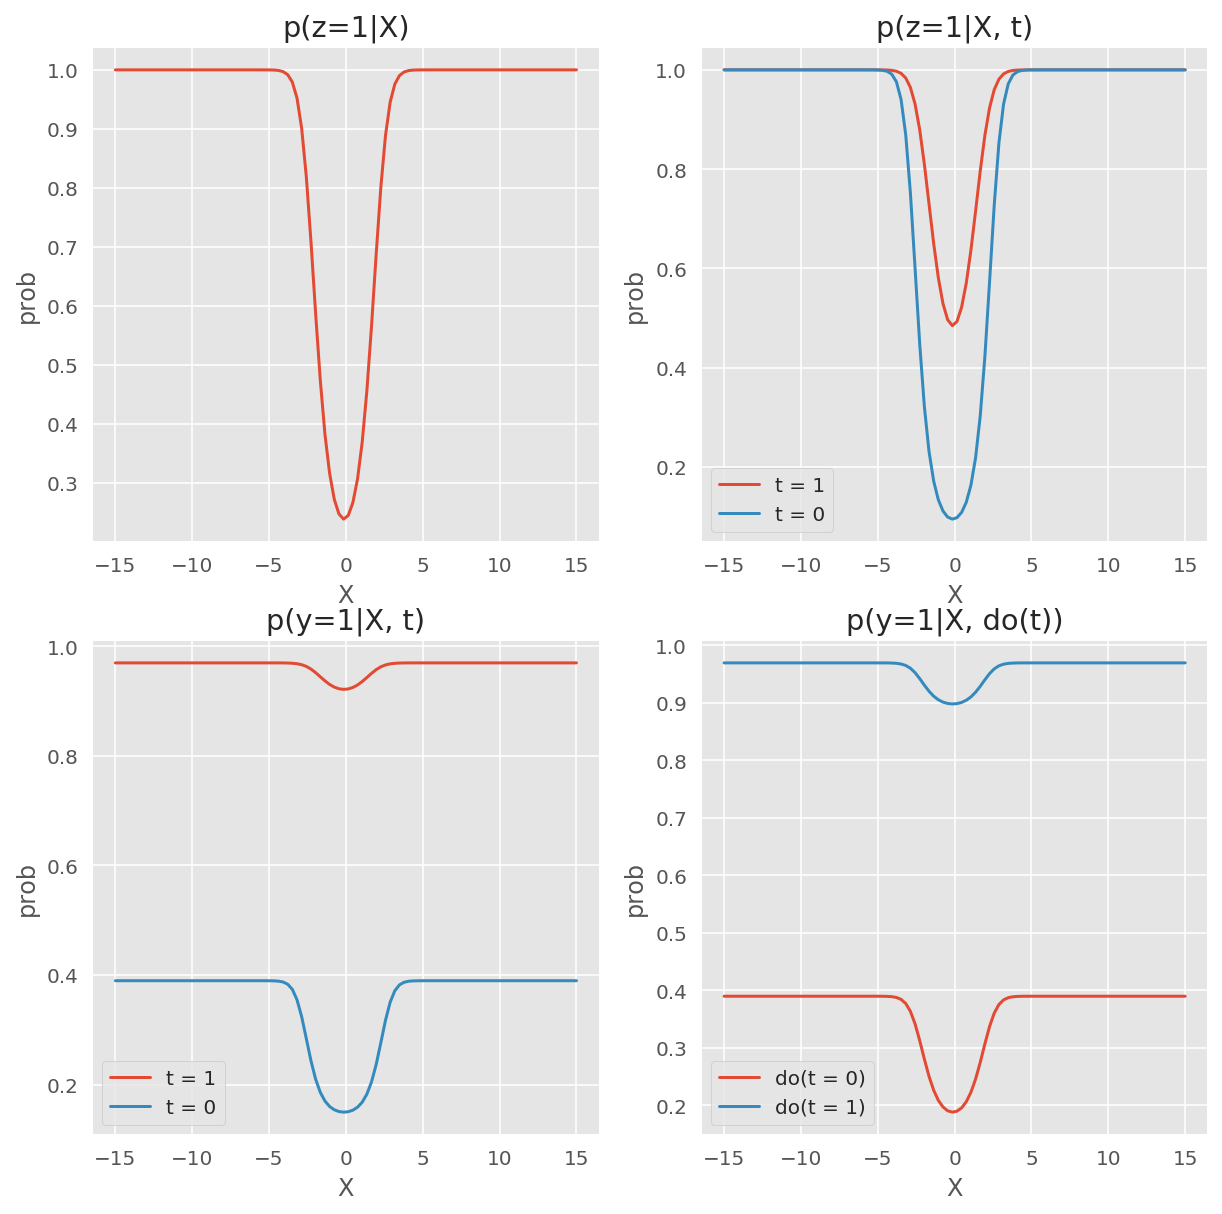

In [474]:
visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1)

In [494]:
# Train two RF models for each treatment 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

rf0 = RandomForestClassifier()
rf1 = RandomForestClassifier()

X0_train= df_train.query("t == 0")['X'].values
y0_train = df_train.query("t == 0")['yf'].values
X1_train = df_train.query("t == 1")['X'].values
y1_train = df_train.query("t == 1")['yf'].values
X0_train.shape = (X0_train.size,1)
X1_train.shape = (X1_train.size,1)

X_test = df_test['X'].values
X_test.shape = (X_test.size,1)
y0_test = df_test['y0'].values
y1_test = df_test['y1'].values

rf0.fit(X0_train, y0_train)
rf1.fit(X1_train, y1_train)

y0_pred = rf0.predict(X_test)
y1_pred = rf1.predict(X_test)

ite_pred = y1_pred - y0_pred
ite_true = y1_test - y0_test

print()
print("Metrics for Twin RF Model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")


Metrics for Twin RF Model with true treatment values:
PEHE: 0.4910
Abs ATE Err.: 0.0690


In [496]:
np.mean(ite_pred) - (df.y1 - df.y0).mean()

0.0716

In [503]:
rf0.predict

<bound method ForestClassifier.predict of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

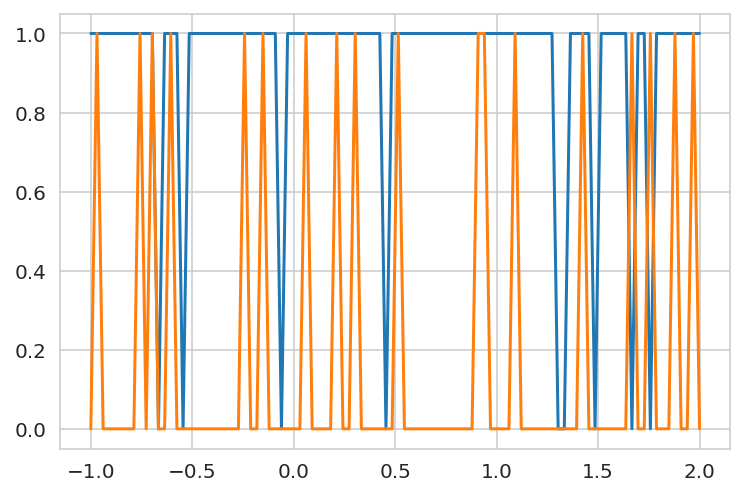

In [507]:
#Plotting the random forest predictions, overfits badly but technically learns the statistics 
#for the training data
y_xt1, y_xt0 = [],[]
xvals = np.linspace(-1,2,100)
for x in xvals:
    y_xt1.append(rf0.predict(np.array([[x]]).T))
    y_xt0.append(rf1.predict(np.array([[x]]).T))
plt.figure()
plt.plot(xvals, y_xt0)
plt.plot(xvals, y_xt1)

In [475]:
# Define pytorch datasets and loaders
class ToyDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.length = data.shape[0]
        self.t = data.loc[:, 't'].values
        self.X = data.loc[:, 'X'].values
        self.y0 = data.loc[:, 'y0'].values
        self.y1 = data.loc[:, 'y1'].values
        self.yf = data.loc[:, 'yf'].values

    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            't': self.t[idx],
            'y0': self.y0[idx],
            'y1': self.y1[idx],
            'yf': self.yf[idx]
        }

    def __len__(self):
        return self.length

class ToyDataLoader(DataLoader):
    def __init__(self, dataset, validation_split=0.2, shuffle=True):
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(validation_split * dataset_size))
        if shuffle:
            np.random.shuffle(indices)
        train_indices, valid_indices = indices[split:], indices[: split]

        self.dataset = dataset
        self.train_sampler = SubsetRandomSampler(train_indices)
        self.valid_sampler = SubsetRandomSampler(valid_indices)

    def collate_fn(self, batch):
        keys = list(batch[0].keys())
        processed_batch = {k: [] for k in keys}
        for _, sample in enumerate(batch):
            for key, value in sample.items():
                processed_batch[key].append(value)
        
        processed_batch['t'] = torch.FloatTensor(processed_batch['t'])
        processed_batch['X'] = torch.FloatTensor(processed_batch['X'])
        processed_batch['y0'] = torch.FloatTensor(processed_batch['y0'])
        processed_batch['y1'] = torch.FloatTensor(processed_batch['y1'])
        processed_batch['yf'] = torch.FloatTensor(processed_batch['yf'])
        return processed_batch

    def train_loader(self, batch_size, num_workers=0):
        train_loader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            sampler=self.train_sampler,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True
        )

        return train_loader

    def test_loader(self, batch_size, num_workers=0):
        test_loader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            sampler=self.valid_sampler,
            num_workers=num_workers,
            pin_memory=True,
            shuffle=False,
            drop_last=True
        )

        return test_loader

    def get_loaders(self, batch_size):
        train_loader = self.train_loader(batch_size)
        test_loader = self.test_loader(batch_size)

        return train_loader, test_loader

In [480]:
# Training Constants
BATCH_SIZE = 8
BATCH_PER_EPOCH = NUM_SAMPLES/BATCH_SIZE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = ToyDataset(df)
dataloader = ToyDataLoader(dataset, validation_split=0.2)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)

Training Results - Epoch 1 - t_aux_loss: 5.8839 y_aux_loss: 2.9466 total_loss: 8.8305 
Validate Results - Epoch 1 - t_aux_loss: 5.7942 y_aux_loss: 2.8226 total_loss: 8.6168 
Training Results - Epoch 2 - t_aux_loss: 5.6090 y_aux_loss: 2.9044 total_loss: 8.5134 
Validate Results - Epoch 2 - t_aux_loss: 5.5578 y_aux_loss: 2.8172 total_loss: 8.3749 
Training Results - Epoch 3 - t_aux_loss: 5.5329 y_aux_loss: 2.9015 total_loss: 8.4344 
Validate Results - Epoch 3 - t_aux_loss: 5.5023 y_aux_loss: 2.8120 total_loss: 8.3143 
Training Results - Epoch 4 - t_aux_loss: 5.5133 y_aux_loss: 2.8973 total_loss: 8.4106 
Validate Results - Epoch 4 - t_aux_loss: 5.4940 y_aux_loss: 2.8264 total_loss: 8.3204 
Training Results - Epoch 5 - t_aux_loss: 5.5079 y_aux_loss: 2.8937 total_loss: 8.4017 
Validate Results - Epoch 5 - t_aux_loss: 5.4945 y_aux_loss: 2.8231 total_loss: 8.3175 
Training Results - Epoch 6 - t_aux_loss: 5.5065 y_aux_loss: 2.8902 total_loss: 8.3966 
Validate Results - Epoch 6 - t_aux_loss: 5.

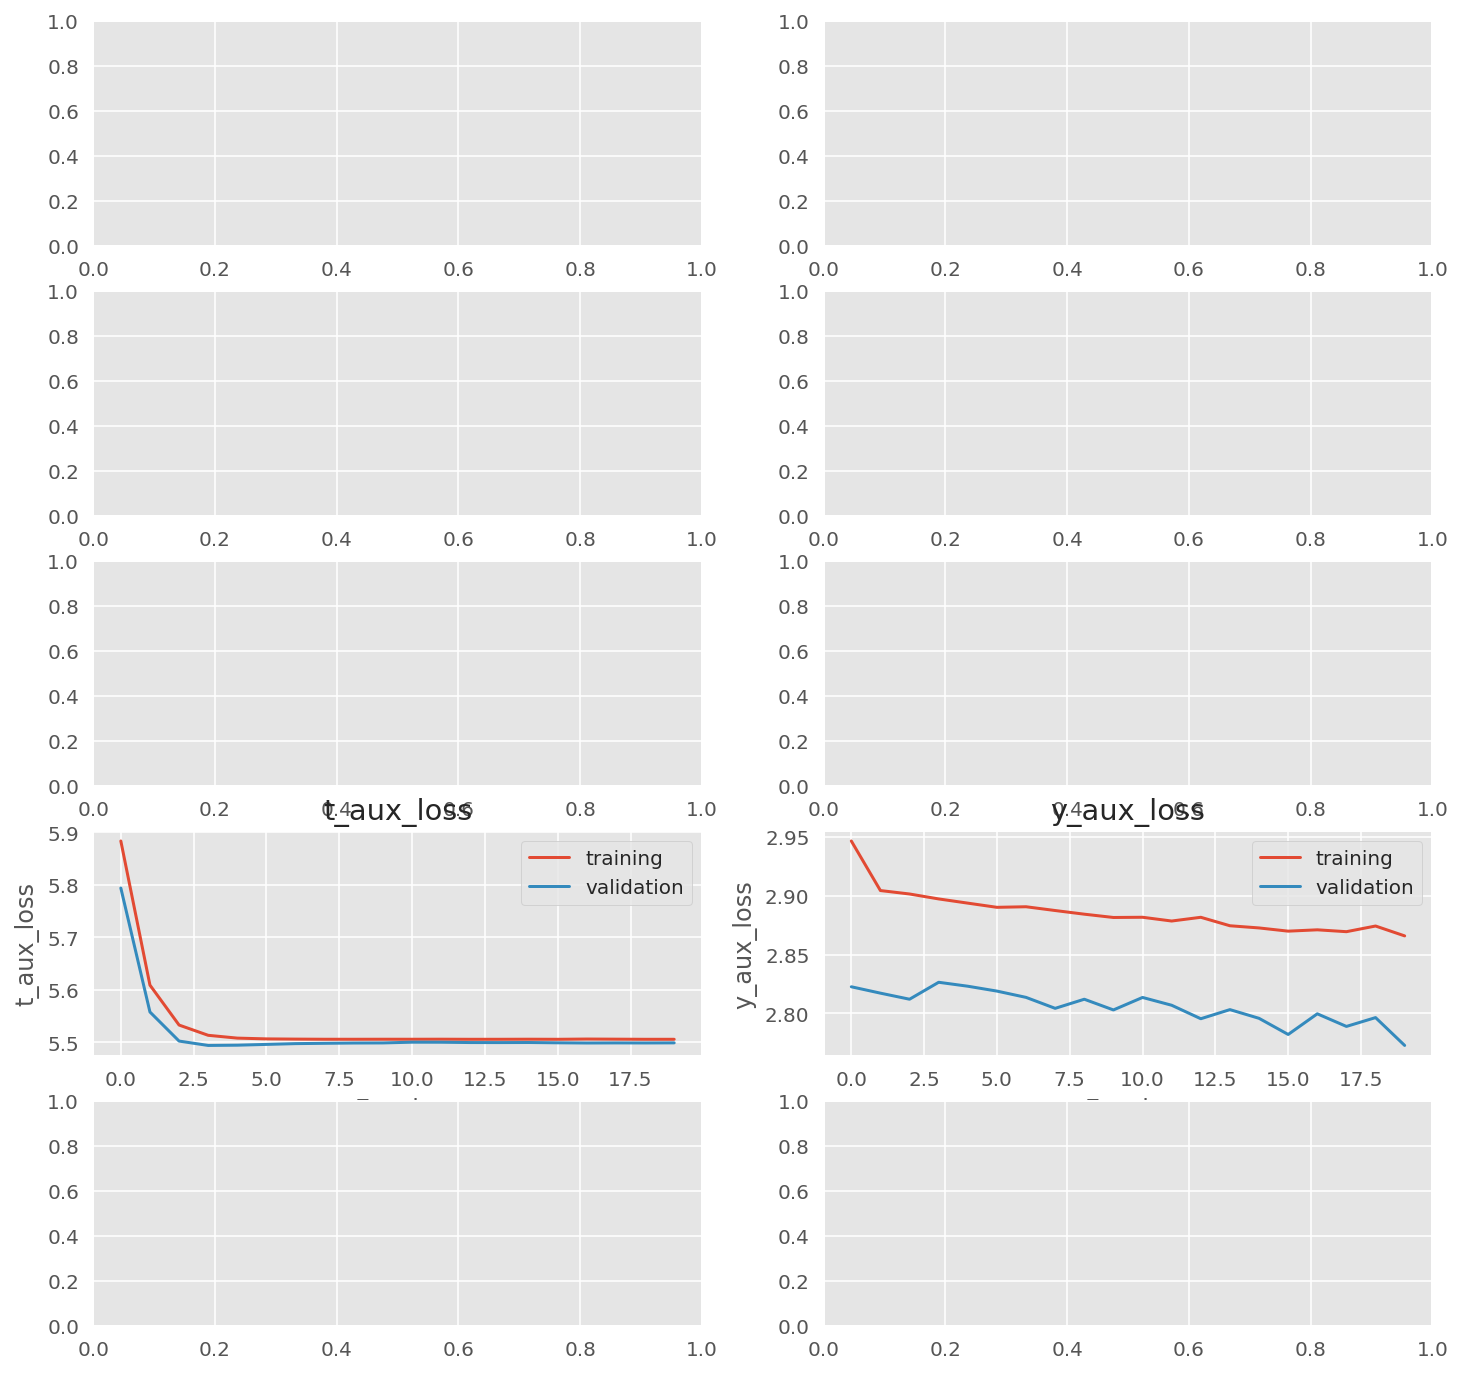

In [491]:
%autoreload 2
from models import *

def kld_loss(mu, var, kld_coef=1.):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #Note that the sum is over the dimensions of z as well as over the units in the batch here
    kld = -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var)#Need to check that this is right, especially with logvar being a var
    return kld_coef * kld

def x_reconc_loss(mean, var, x):
    return -dist.normal.Normal(mean,torch.sqrt(var)).log_prob(x).sum()

def run_cevae(num_epochs, lr, train_loader, test_loader):
    model = CEVAE(1, activation=nn.ELU(), device=device, hidden_dim=4)
    optimizer = Adam(model.parameters(), lr=lr)

    yf_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')#t and y should in principle form one classification problem
    t_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')#Sum because kld_loss assumes sum
    #x_loss_fn = nn.MSELoss(reduction='sum') <- this is either complicated expression or we use the dist library

    t_aux_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')#This could be mean since it doesn't couple with the VAE
    y_aux_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

    def _prepare_batch(batch):
        x = batch['X'].to(device)
        t = batch['t'].to(device)
        yf = batch['yf'].to(device)
        if len(x.shape) == 1:#Temporary, making sure that shapes are bs x dim
            x = x[:,None]
            yf = yf[:,None]
            t = t[:,None]
        return x, t, yf

    def process_function(engine, batch):
        optimizer.zero_grad()
        model.train()
        x, t, yf = _prepare_batch(batch)
        
        if len(x.shape) == 1:
            print("Shapes in process_function: {} {} {}".format(x.shape, t.shape, y.shape))
        (z_mean, z_var, x_mean, x_var, t_logits, 
            y_logits, tinfer_logit, yinfer_logit) = model(x,t,yf)

        # aux losses
        t_aux_loss = t_aux_loss_fn(tinfer_logit, t)
        y_aux_loss = y_aux_loss_fn(yinfer_logit, yf)

        tr_loss = t_aux_loss + y_aux_loss
        tr_loss.backward()
        optimizer.step()

        return (
            t_aux_loss.item(),
            y_aux_loss.item()
        )

    def evaluate_function(engine, batch):#This needs to be changed or maybe the eval_metrics?
        model.eval()
        with torch.no_grad():
            x, t, yf = _prepare_batch(batch)
            #How should the model be operated during test time? Technically were not allowed to use
            #t or yf. 
            (z_mean, z_var, x_mean, x_var, t_logits, 
                y_logits, tinfer_logit, yinfer_logit) = model(x,t,yf)#Do we need this for anything?
            
            #ITE inference
            E_y_x_do1, E_y_x_do0 = (0,0)
            ITE_x = 0
            
            return {
                "E_y_x_do1":E_y_x_do1,"E_y_x_do0":E_y_x_do0,"ITE_x":ITE_x,
                "y1":batch['y1'],"y0":batch['y0'],
                "y_logits":y_logits, "yinfer_logit":yinfer_logit, "yf":yf,
                "x_mean":x_mean,"x_var":x_var,"x":x,
                "t_logits":t_logits, "tinfer_logit":tinfer_logit,"t":t,
                "z_mean":z_mean, "z_var":z_var
            }

    trainer = Engine(process_function)
    evaluator = Engine(evaluate_function)
    train_evaluator = Engine(evaluate_function)
    pbar = ProgressBar(persist=False)

    #ignite_metrics.RunningAverage(output_transform=lambda x: x[0])\
    #    .attach(trainer, 'tr_factual_loss')
    # pbar.attach(trainer, ['tr_factual_loss'])


    # eval_metrics
    eval_metrics = {
        # PEHE is defined as ((y1 - y0)_true - (y1 - y0)_pred)**2 .mean() for each patient
        #"pehe": ignite_metrics.Average(
        #   output_transform=lambda x: (x["ITE_x"] - (x["y1"] - x["y0"])).pow(2).mean()),
        #"mae_ate": ignite_metrics.Average(
        #   output_transform=lambda x: ((x["ITE_x"] - (x["y1"] - x["y0"])).mean())),
        #"y_reconc_loss": ignite_metrics.Loss(
        #    yf_loss_fn, output_transform=lambda x: [x["y_logits"], x["yf"]]),
        #"x_reconc_loss": ignite_metrics.Average(
        #    output_transform=lambda x: x_reconc_loss(x["x_mean"], x["x_var"], x["x"])),
        #"kld_loss": ignite_metrics.Loss(
        #    kld_loss, output_transform=lambda x: [x["z_mean"], x["z_var"]]),
        #"t_reconc_loss": ignite_metrics.Loss(
        #    t_loss_fn, output_transform=lambda x: [x["t_logits"], x["t"]]),
        "t_aux_loss": ignite_metrics.Loss(
            t_loss_fn, output_transform=lambda x: [x["tinfer_logit"], x["t"]]),
        "y_aux_loss": ignite_metrics.Loss(
            yf_loss_fn, output_transform=lambda x: [x["yinfer_logit"], x["yf"]])
    }
    
    eval_metrics['total_loss'] = (eval_metrics["t_aux_loss"] + 
                                  eval_metrics["y_aux_loss"])

    for eval_engine in [evaluator, train_evaluator]:#What is this about? Something to do with the continuous tracking of losses?
        for name, metric in eval_metrics.items():
            metric.attach(eval_engine, name)

    tr_metrics_history = {k: [] for k in eval_metrics.keys()}
    val_metrics_history = {k: [] for k in eval_metrics.keys()}

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_validation(engine):
        if device == "cuda":
            torch.cuda.synchronize()
        train_evaluator.run(train_loader)
        evaluator.run(test_loader)

    def handle_logs(evaluator, trainer, mode, metrics_history):
        metrics = evaluator.state.metrics
        # import pdb; pdb.set_trace()
        for key, value in evaluator.state.metrics.items():
            metrics_history[key].append(value)

        print_str = f"{mode} Results - Epoch {trainer.state.epoch} - "+\
                    f"t_aux_loss: {metrics['t_aux_loss']:.4f} " +\
                    f"y_aux_loss: {metrics['y_aux_loss']:.4f} " +\
                    f"total_loss: {metrics['total_loss']:.4f} "
                    #f"PEHE: {metrics['pehe']:.4f} " +\
                    #f"MAE ATE: {metrics['mae_ate']:.4f} " +\
                    #f"y_reconc_loss: {metrics['y_reconc_loss']:.4f} " +\
                    #f"x_reconc_loss: {metrics['x_reconc_loss']:.4f} " +\
                    #f"t_reconc_loss: {metrics['t_reconc_loss']:.4f} " +\
                    #f"kld_loss: {metrics['kld_loss']:.4f} " +\
                    #f"precision: {metrics['factual_precision']:.4f}."
                    # f"true ITE: {metrics['ite_true'].sum():.4f} " +\
                    # f"pred ITE: {metrics['ite_pred'].sum():.4f} " +\
                    # f"acc: {metrics['factual_acc']:.4f} "
                    # f"recall: {metrics['factual_recall']:.4f} " +\
                    # f"precision: {metrics['factual_precision']:.4f}."
        print(print_str)

    train_evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Training',
        tr_metrics_history
    )
    evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Validate',
        val_metrics_history
    )

    trainer.run(train_loader, max_epochs=num_epochs)

    # Plot training curve
    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(5, 2, figsize=(12, 12))
        """sns.lineplot(x=range(num_epochs), y=tr_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='validation')
        ax[0, 0].set_xlabel('Epochs')
        ax[0, 0].set_ylabel('Total Loss')
        ax[0, 0].set_title('Total Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['y_reconc_loss'], ax=ax[0, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['y_reconc_loss'], ax=ax[0, 1], err_style=None, label='validation')
        ax[0, 1].set_xlabel('Epochs')
        ax[0, 1].set_ylabel('y_reconc_loss')
        ax[0, 1].set_title('yf Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['x_reconc_loss'], ax=ax[1, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['x_reconc_loss'], ax=ax[1, 0], err_style=None, label='validation')
        ax[1, 0].set_xlabel('Epochs')
        ax[1, 0].set_ylabel('x_reconc_loss')
        ax[1, 0].set_title('X Reconstruction Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['t_reconc_loss'], ax=ax[1, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['t_reconc_loss'], ax=ax[1, 1], err_style=None, label='validation')
        ax[1, 1].set_xlabel('Epochs')
        ax[1, 1].set_ylabel('t_reconc_loss')
        ax[1, 1].set_title('t_reconc_loss')

        #fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['pehe'], ax=ax[2, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['pehe'], ax=ax[2, 0], err_style=None, label='validation')
        ax[2, 0].set_xlabel('Epochs')
        ax[2, 0].set_ylabel('PEHE')
        ax[2, 0].set_title('PEHE')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['mae_ate'], ax=ax[2, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['mae_ate'], ax=ax[2, 1], err_style=None, label='validation')
        ax[2, 1].set_xlabel('Epochs')
        ax[2, 1].set_ylabel('MAE ATE')
        ax[2, 1].set_title('ATE')"""
        
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['t_aux_loss'], ax=ax[3, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['t_aux_loss'], ax=ax[3, 0], err_style=None, label='validation')
        ax[3, 0].set_xlabel('Epochs')
        ax[3, 0].set_ylabel('t_aux_loss')
        ax[3, 0].set_title('t_aux_loss')
        
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['y_aux_loss'], ax=ax[3, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['y_aux_loss'], ax=ax[3, 1], err_style=None, label='validation')
        ax[3, 1].set_xlabel('Epochs')
        ax[3, 1].set_ylabel('y_aux_loss')
        ax[3, 1].set_title('y_aux_loss')
        
        #sns.lineplot(x=range(num_epochs), y=tr_metrics_history['kld_loss'], ax=ax[4, 0], err_style=None, label='training')
        #sns.lineplot(x=range(num_epochs), y=val_metrics_history['kld_loss'], ax=ax[4, 0], err_style=None, label='validation')
        #ax[4, 0].set_xlabel('Epochs')
        #ax[4, 0].set_ylabel('kld_loss')
        #ax[4, 0].set_title('kld_loss')
    return model

LR = 0.001
NUM_EPOCHS = 20
model = run_cevae(NUM_EPOCHS, LR, train_loader, test_loader)

In [183]:
next(iter(test_loader))

{'X': tensor([-6.6263, -2.5818,  1.4891, -1.9366, -1.2981,  0.2595,  0.9739, -4.4594]),
 't': tensor([1., 1., 1., 1., 1., 1., 0., 0.]),
 'y0': tensor([0., 0., 0., 0., 0., 0., 0., 0.]),
 'y1': tensor([1., 1., 1., 1., 1., 1., 1., 1.]),
 'yf': tensor([1., 1., 1., 1., 1., 1., 0., 0.])}

In [492]:
%autoreload 2
def predict_y(x,t):
    if type(x) != torch.Tensor:
        x = torch.Tensor([x])
        t = torch.Tensor([t])
    if len(x.shape) == 1:
        x = x[:,None]
    if len(t.shape) == 1:
        t = t[:,None]
    yf = torch.zeros_like(x)
    (z_mean, z_var, x_mean, x_var, t_logits, 
                y_logits, tinfer_logit, yinfer_logit) = model(x,t,yf)
    return torch.sigmoid(yinfer_logit)

In [406]:
predict_y(-2,0).item()

0.20473505556583405

In [407]:
x, t = torch.Tensor([[-5]]), torch.Tensor([[0]])
print(model.y_infer.q_outcome_nn(x))
print(model.y_infer.q_outcome_t1_nn(model.y_infer.q_outcome_nn(x)))

tensor([[0., 0.]], grad_fn=<ReluBackward0>)
(tensor([[2.9488]], grad_fn=<ClampBackward>),)


In [408]:
print(model.y_infer)
print(model.y_infer.q_outcome_nn[0].weight, model.y_infer.q_outcome_nn[2].weight)

yInferNet(
  (q_outcome_nn): FullyConnected(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=2, out_features=2, bias=True)
    (7): ReLU()
  )
  (q_outcome_t0_nn): BernoulliNet(
    (fc): FullyConnected(
      (0): Linear(in_features=2, out_features=1, bias=True)
    )
  )
  (q_outcome_t1_nn): BernoulliNet(
    (fc): FullyConnected(
      (0): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)
Parameter containing:
tensor([[-0.7644],
        [ 0.8926]], requires_grad=True) Parameter containing:
tensor([[ 0.5832, -0.5691],
        [-0.1000,  0.3819]], requires_grad=True)


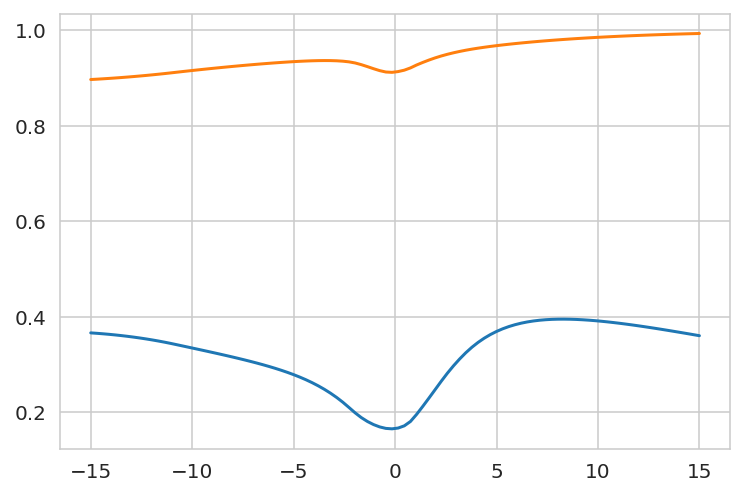

In [493]:
y_xt1, y_xt0 = [],[]
xvals = np.linspace(-15,15,100)
for x in xvals:
    y_xt1.append(predict_y(x,1).item())
    y_xt0.append(predict_y(x,0).item())
plt.figure()
plt.plot(xvals, y_xt0)
plt.plot(xvals, y_xt1)

In [486]:
%autoreload 2
X_t1_logits = torch.zeros(0)
X_t0_logits = torch.zeros(0)
for d in iter(test_loader):
    X,t,yf = d['X'], d['t'], d['yf']
    X,t,yf = X[:,None], t[:,None], yf[:,None]
    (z_mean, z_var, x_mean, x_var, t_logits, 
                y_logits, tinfer_logit, yinfer_logit) = model(X,t,yf)
    X_t1_logits = torch.cat((X_t1_logits, yinfer_logit[t==1]))
    X_t0_logits = torch.cat((X_t0_logits, yinfer_logit[t==0]))

In [497]:
print(torch.sigmoid(X_t1_logits).mean())
print(torch.sigmoid(X_t0_logits).mean())
ate_estimate = torch.sigmoid(X_t1_logits).mean() - torch.sigmoid(X_t0_logits).mean()
print(ate_estimate - (df.y1 - df.y0).mean())

tensor(0.9654, grad_fn=<MeanBackward0>)
tensor(0.1653, grad_fn=<MeanBackward0>)
tensor(0.1407, grad_fn=<SubBackward0>)
